In [1]:
import pandas as pd
import re
import os
import numpy as np
import glob
from datetime import datetime
import geopandas as gpd
import json
from shapely.geometry import shape, GeometryCollection
from rasterio.plot import show
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

import shutil
import rasterio
%matplotlib inline

In [2]:
from GPSPhoto import gpsphoto
from pyproj import Proj, transform
import cv2

In [3]:
json_folder = r"C:\Users\James Cho G7\Documents\James Python\DS\Drone\Geojson"
img_folder = r'C:\Users\James Cho G7\Documents\James Python\DS\Drone\TIFF\interbulgo'
jpg_folder = r'D:\drone images\Unknown'

In [4]:
files = glob.glob(os.path.join(img_folder,'*.tiff'))

files

['C:\\Users\\James Cho G7\\Documents\\James Python\\DS\\Drone\\TIFF\\interbulgo\\인터불고 5179 v2.tiff',
 'C:\\Users\\James Cho G7\\Documents\\James Python\\DS\\Drone\\TIFF\\interbulgo\\인터불고 5179 v3.tiff',
 'C:\\Users\\James Cho G7\\Documents\\James Python\\DS\\Drone\\TIFF\\interbulgo\\인터불고 5179.tiff',
 'C:\\Users\\James Cho G7\\Documents\\James Python\\DS\\Drone\\TIFF\\interbulgo\\인터불고 5181.tiff',
 'C:\\Users\\James Cho G7\\Documents\\James Python\\DS\\Drone\\TIFF\\interbulgo\\인터불고 전면.tiff',
 'C:\\Users\\James Cho G7\\Documents\\James Python\\DS\\Drone\\TIFF\\interbulgo\\인터불고.tiff']

In [5]:
import rasterio

wgs84_crs = rasterio.crs.CRS({"init": "epsg:4326"})
e5179_crs = rasterio.crs.CRS({"init": "epsg:5181"})

dataset = rasterio.open(files[3], mode='r+')
dataset.crs = e5179_crs

In [6]:
dataset.crs

CRS.from_epsg(5181)

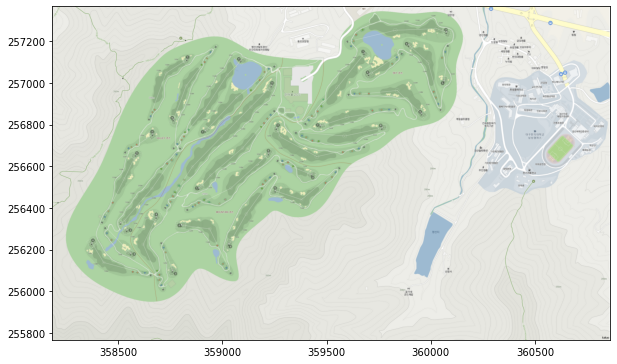

<AxesSubplot:>

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))
rasterio.plot.show(dataset.read(), transform=dataset.transform)

In [43]:
im1 = dataset.read()
im1 = im1.transpose(1, 2, 0)[:,:,:3]
im1_blurred = cv2.medianBlur(im1, 21)




In [44]:
im1.shape

(966, 1617, 3)

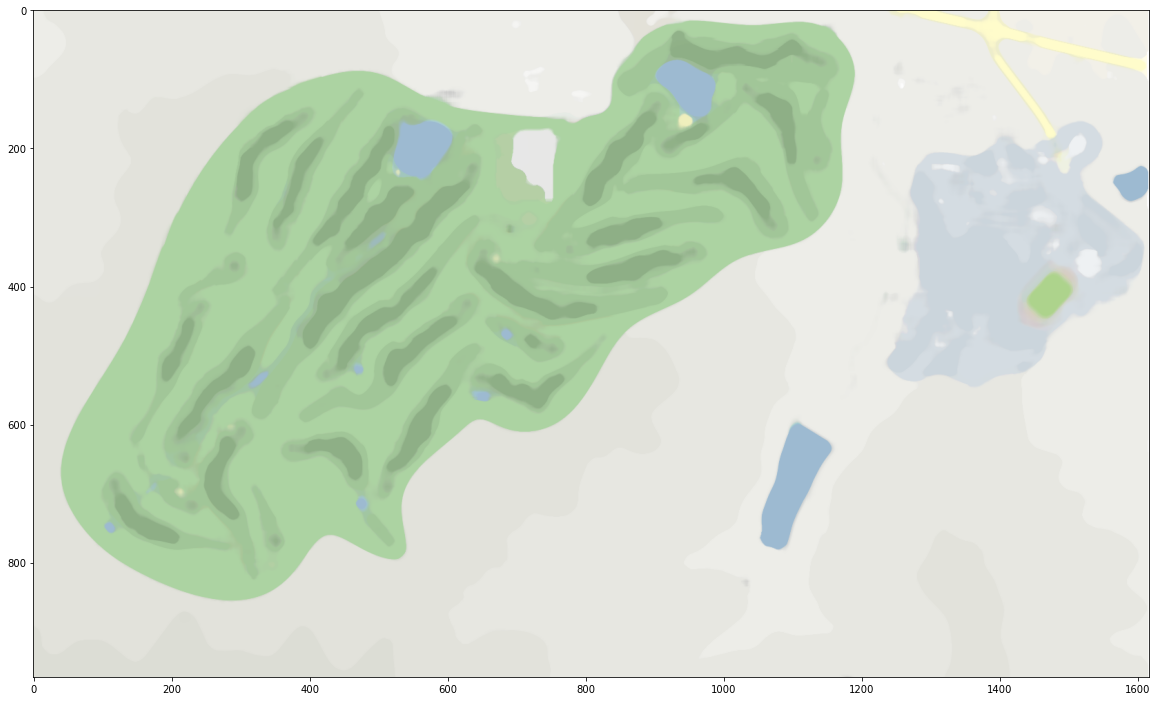

In [45]:

fig, ax = plt.subplots(figsize=(20, 20))
plt.imshow(im1_blurred)

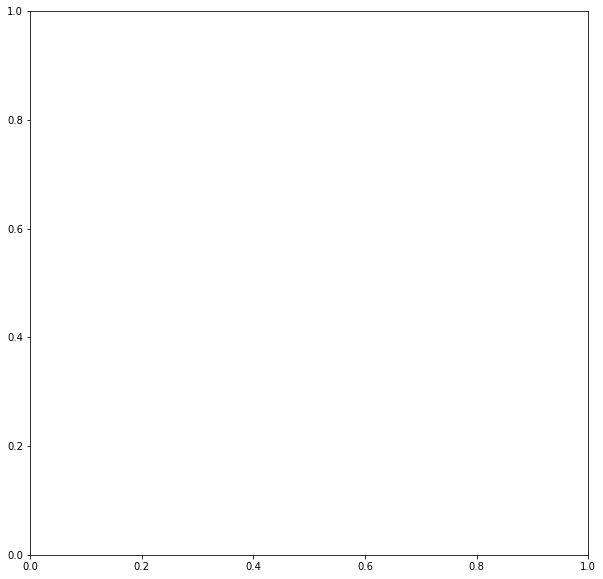

In [18]:
fig, ax = plt.subplots(figsize=(10, 10))

temp = im1.copy()

cv2.imshow("Window", im1_blurred)
cv2.waitKey(0)
cv2.destroyAllWindows()

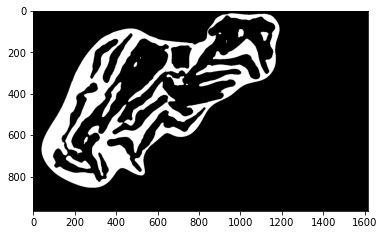

In [46]:
sought = [172,211,162]

mask = np.all(im1_blurred==sought,axis=2) * np.uint8(255)
plt.imshow(mask, cmap="gray")

In [47]:
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

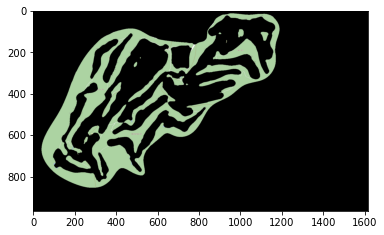

In [48]:
result = cv2.bitwise_and(im1, im1, mask=mask)
plt.imshow(result)

In [49]:
contours, hierarchy = cv2.findContours(image=mask, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)

In [50]:
image_copy = im1_blurred.copy()
c = max(contours, key = cv2.contourArea)
image_copy = cv2.drawContours(image=image_copy, contours=[c], contourIdx=-1, color=(255,1,1), thickness=2, lineType=cv2.LINE_AA)

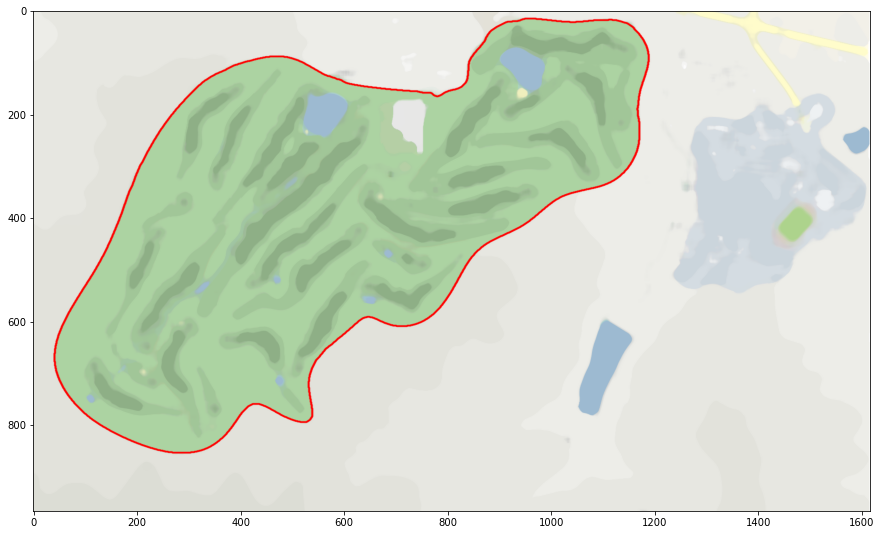

In [51]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.imshow(image_copy)

In [52]:
c.shape

(2998, 1, 2)

In [53]:

epsilon = 0.001*cv2.arcLength(c,True)
approx = cv2.approxPolyDP(c,epsilon,True)

In [54]:
image_copy = im1_blurred.copy()
image_copy = cv2.drawContours(image=image_copy, contours=[approx], contourIdx=-1, color=(255,1,1),
                              thickness=2, lineType=cv2.LINE_AA)

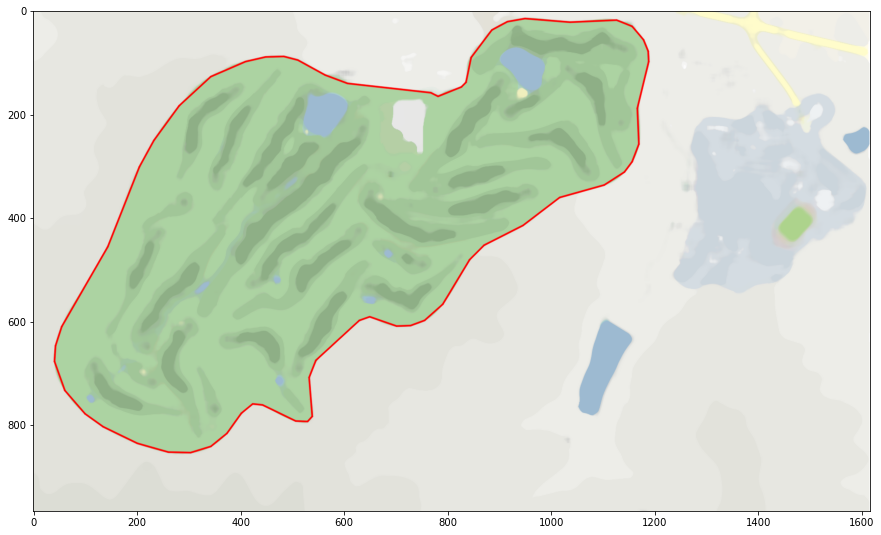

In [55]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.imshow(image_copy)

In [56]:
def convert_latlon(a,dataset_):
    return dataset_.xy(a[1],a[0])

In [57]:
approx.squeeze().shape

(59, 2)

In [58]:
approx_geo = np.apply_along_axis(lambda p: convert_latlon(p, dataset), -1, approx)

In [59]:
approx_geo


array([[[360137.84314203, 257271.53233452]],

       [[360101.4252735 , 257314.5716337 ]],

       [[360051.76454369, 257334.43592562]],

       [[359902.78235424, 257327.81449498]],

       [[359758.76623778, 257339.4019986 ]],

       [[359702.48407733, 257329.46985264]],

       [[359652.82334752, 257302.98413007]],

       [[359586.6090411 , 257215.25017407]],

       [[359570.05546449, 257135.79300637]],

       [[359555.15724555, 257120.89478742]],

       [[359480.66615083, 257091.09834953]],

       [[359457.49114358, 257102.68585316]],

       [[359190.97856025, 257132.48229105]],

       [[359119.79818085, 257158.96801361]],

       [[359032.06422484, 257206.97338577]],

       [[358987.36956801, 257218.56088939]],

       [[358929.4320499 , 257216.90553173]],

       [[358864.87310114, 257202.00731278]],

       [[358753.96413789, 257154.00194063]],

       [[358652.9873206 , 257061.30191165]],

       [[358571.87479524, 256950.3929484 ]],

       [[358525.52478075, 256865.9

In [60]:
from shapely.geometry import Polygon

contour = np.squeeze(approx_geo)
polygon = Polygon(contour)

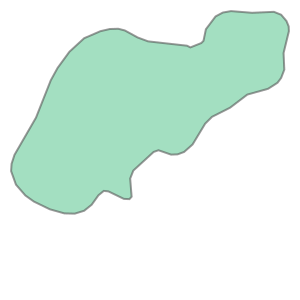

In [61]:
polygon

In [ ]:
gpd.GeoSeries([polygon])

In [65]:
gdf = gpd.GeoSeries([polygon], crs=5181)
gdf.crs

<Projected CRS: EPSG:5181>
Name: Korea 2000 / Central Belt
Axis Info [cartesian]:
- X[north]: Northing (metre)
- Y[east]: Easting (metre)
Area of Use:
- name: Republic of Korea (South Korea) - between 126°E and 128°E - mainland and nearshore.
- bounds: (126.0, 33.96, 128.0, 38.33)
Coordinate Operation:
- name: Korea Central Belt
- method: Transverse Mercator
Datum: Geocentric datum of Korea
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [69]:
gdf = gdf.to_crs(4326)
gdf = gpd.GeoDataFrame(geometry=gdf)

In [67]:
gdf.to_file(os.path.join(json_folder,'인터불고1_4326.geojson'), driver='GeoJSON')

In [70]:
gdf

,geometry
0,"POLYGON ((128.77152 35.79973, 128.77113 35.800..."
